In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random

## Define the paths

In [ ]:
# Define the paths
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

# Classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Function to count images in each class
def count_images_in_classes(base_path, classes):
    counts = {}
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        counts[cls] = len(os.listdir(class_path))
    return counts

# Count images in training and testing sets
training_counts = count_images_in_classes(training_path, classes)
testing_counts = count_images_in_classes(testing_path, classes)


In [ ]:
# Plotting the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()



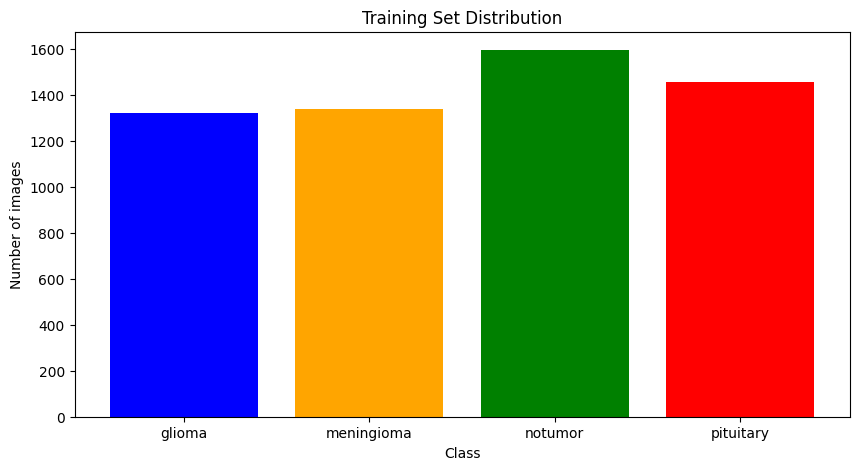

In [ ]:
# Plot distributions
plot_distribution(training_counts, 'Training Set Distribution')



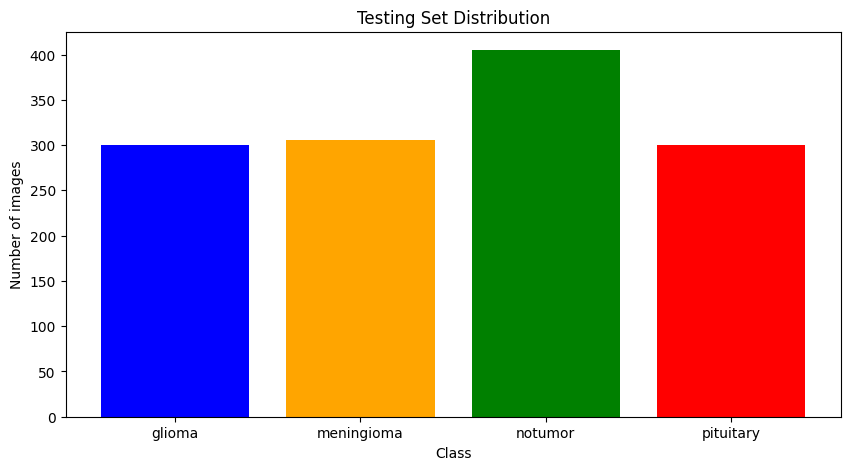

In [ ]:
plot_distribution(testing_counts, 'Testing Set Distribution')

## Display sample images

In [ ]:
# Function to display sample images from each class
def display_sample_images(base_path, classes, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(base_path, cls)
        images = os.listdir(class_path)
        for j in range(num_samples):
            img_path = os.path.join(class_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


Training set Sample images



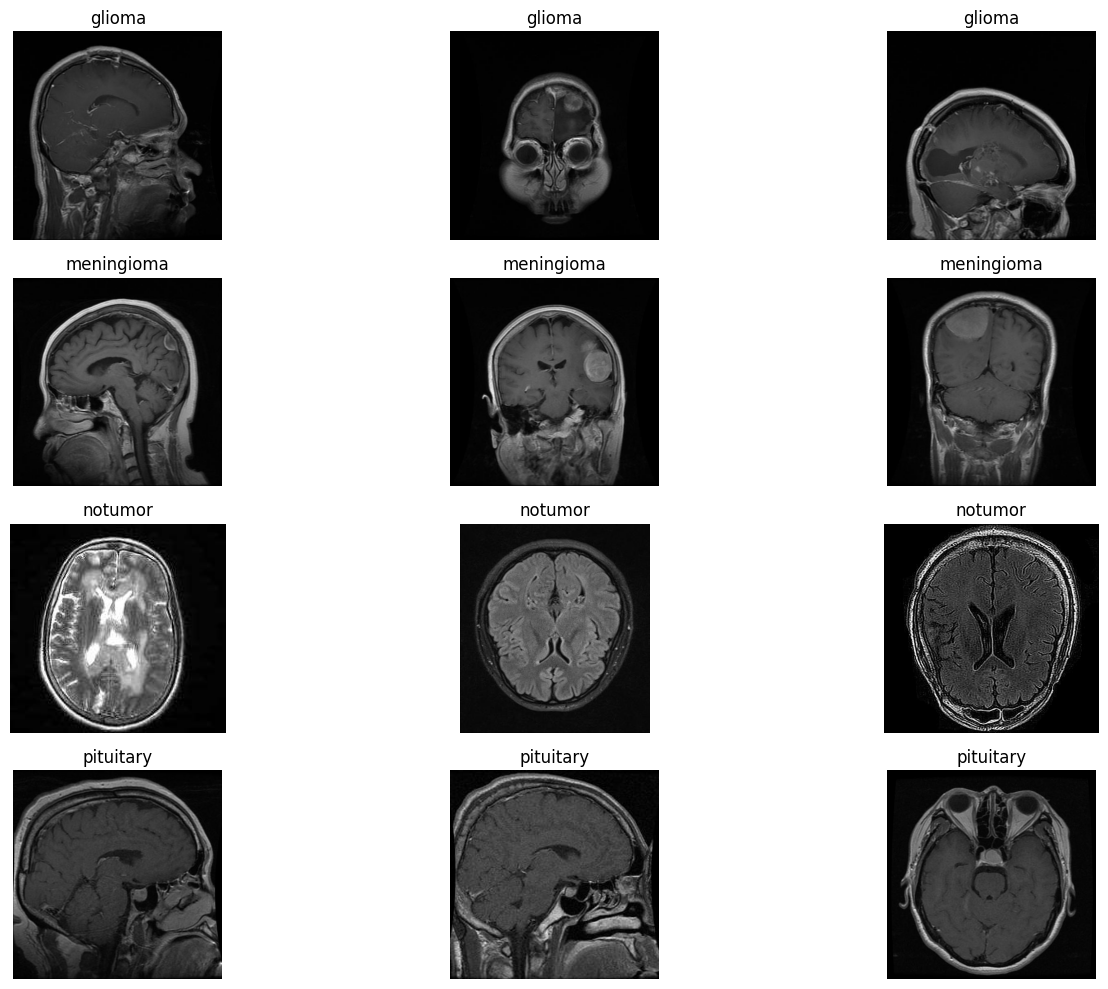

In [ ]:
# Display sample images from training set
display_sample_images(training_path, classes)



## Testing set Sample images

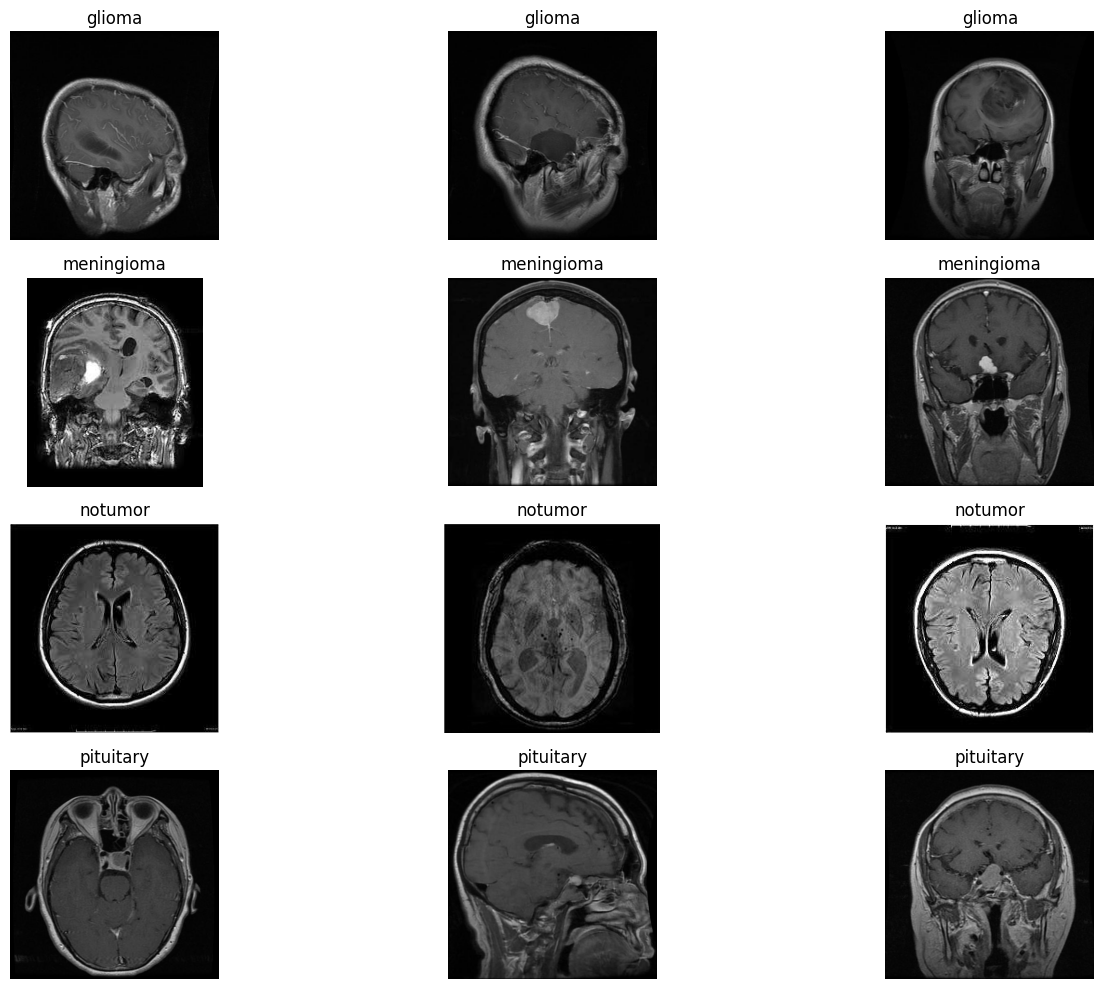

In [ ]:
# Display sample images from testing set
display_sample_images(testing_path, classes)


## Image properties

In [ ]:
# Function to check image properties
def check_image_properties(base_path, classes):
    properties = []
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = cv2.imread(img_path)
        properties.append((cls, img.shape))
    return properties

# Check image properties
training_properties = check_image_properties(training_path, classes)
testing_properties = check_image_properties(testing_path, classes)



In [ ]:
print("Training set image properties:")
for cls, prop in training_properties:
    print(f"Class: {cls}, Image Shape: {prop}")



Training set image properties:
Class: glioma, Image Shape: (512, 512, 3)
Class: meningioma, Image Shape: (512, 512, 3)
Class: notumor, Image Shape: (222, 227, 3)
Class: pituitary, Image Shape: (512, 512, 3)


In [ ]:
print("\nTesting set image properties:")
for cls, prop in testing_properties:
    print(f"Class: {cls}, Image Shape: {prop}")


Testing set image properties:
Class: glioma, Image Shape: (512, 512, 3)
Class: meningioma, Image Shape: (442, 442, 3)
Class: notumor, Image Shape: (262, 236, 3)
Class: pituitary, Image Shape: (512, 512, 3)


## Model From Strach 01

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import Hyperband
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband


In [ ]:
# Define image dimensions and paths
img_height, img_width = 128, 128
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

# Define data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_m1 = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_m1= train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_m1 = test_datagen.flow_from_directory(
    testing_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:

# Define the model-building function for Hyperband
def build_model(hp):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout Layer
    model.add(layers.Dropout(0.25))

    # Flattening
    model.add(layers.Flatten())

    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))

    # Another Dropout Layer
    model.add(layers.Dropout(0.5))

    # Output layer for 4 classes
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameters for the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.00001])

    # Compile the model with chosen optimizer and learning rate
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
# Initialize the Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='/content/drive/MyDrive/umar',
    project_name='strach_m1'
)

# Early stopping callback to stop training when no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_m1,  # Training data generator
    validation_data=validation_m1,  # Validation data generator
    epochs=10,
    callbacks=[early_stopping]
)


Reloading Tuner from /content/drive/MyDrive/umar/strach_m1/tuner0.json


In [ ]:
# Get the best model found by the tuner
m1_best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
m1_best_model.summary()

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,510,084 (120.20 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

Best Hyperparameters:
optimizer: adam
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0


In [ ]:
history = m1_best_model.fit(
    train_m1,  # Training data generator
    validation_data=validation_m1,  # Validation data generator
    epochs=20,  # You can adjust the number of epochs
    callbacks=[early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3069s 21s/step - accuracy: 0.9065 - loss: 0.2587 - val_accuracy: 0.7581 - val_loss: 0.7343
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9437 - loss: 0.1822 - val_accuracy: 0.7564 - val_loss: 0.7822
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.9526 - loss: 0.1487 - val_accuracy: 0.7651 - val_loss: 0.8316
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.9572 - loss: 0.1245 - val_accuracy: 0.7686 - val_loss: 0.9399


In [ ]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy = m1_best_model.evaluate(test_m1)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 660s 17s/step - accuracy: 0.8531 - loss: 0.4673
Test Accuracy: 85.28%


In [ ]:
from sklearn.metrics import classification_report

# Predict labels for the test set
test_m1.reset()  # Reset generator to avoid incomplete batches
y_pred = m1_best_model.predict(test_m1)
y_pred = y_pred.argmax(axis=1)

# Get the true labels from the test generator
y_true = test_m1.classes

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_m1.class_indices.keys()))


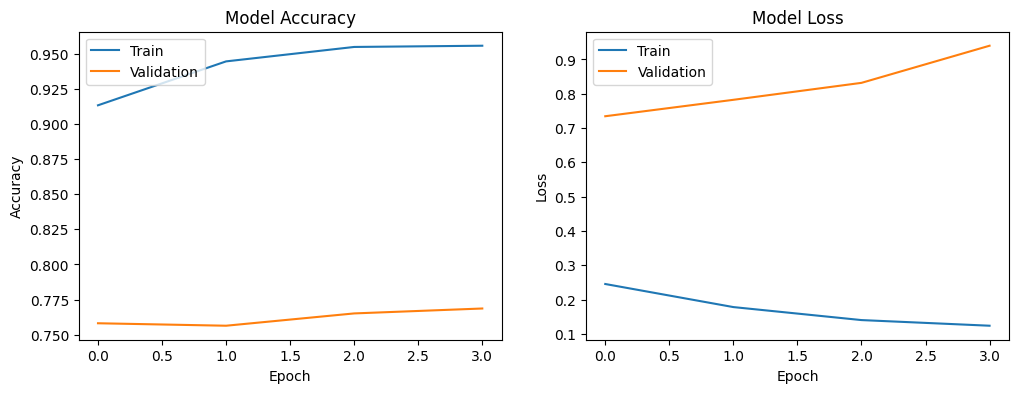

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
